# Introduction:
Following are some of the features that we'll engineer and use in this notebook
1. GuestRooms/Rooms: GuestRooms to Rooms ratio 
2. Number of non-guest rooms: numberOfRooms - GuestRooms
3. Rooms/Floors: Number of rooms per floor
4. Attic/squareMeters:  Attic size to total house size ratio
5. Basement/squareMeters: Basement size to total house size ratio
6. Garage/squareMeters: Garage size to total house size ratio
7. Group city codes into blocks
8. Average price per block

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
from pathlib import Path
import xgboost as xgb
import lightgbm as lgbm
import catboost
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from IPython.display import display
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
import optuna
from sklearn.preprocessing import StandardScaler
from category_encoders import LeaveOneOutEncoder, TargetEncoder, woe

In [3]:
from warnings import filterwarnings
filterwarnings("ignore")

# Loading Data

In [19]:
# setting a base path variable for easy access
BASE_PATH = Path("/kaggle/input/playground-series-s3e6")
train = pd.read_csv(BASE_PATH / "train.csv").drop(columns=["id"])

test = pd.read_csv(BASE_PATH / "test.csv")
# we need the test id column to make the submission
test_idx = test.id
test = test.drop(columns=["id"])

In [20]:
all_datasets = {"train": train, "test": test}

# Setting Upper and Lower Bounds
As taken from https://www.kaggle.com/code/khawajaabaidullah/ps3e6-setting-upper-bounds-may-help

In [21]:
for dataset in all_datasets.values():
    dataset["attic"] = dataset.attic.clip(upper=10000, lower=10)
    dataset["floors"] = dataset.floors.clip(upper=100)
    dataset["squareMeters"] = dataset.squareMeters.clip(upper=99999)
    dataset["basement"] = dataset.basement.clip(upper=10000, lower=10)
    dataset["garage"] = dataset.garage.clip(upper=1000, lower=100)
    dataset["made"] = dataset.made.clip(upper=2021)
    dataset["cityCode"] = dataset.cityCode.clip(upper=99999)

## Checking for missing values

In [5]:
# pd.concat([dataset.isnull().sum().rename(f"Missing in {dataset_name}") 
#                for dataset_name, dataset in all_datasets.items()],
#                  axis=1)

,Missing in train,Missing in test
squareMeters,0,0.0
numberOfRooms,0,0.0
hasYard,0,0.0
hasPool,0,0.0
floors,0,0.0
cityCode,0,0.0
cityPartRange,0,0.0
numPrevOwners,0,0.0
made,0,0.0
isNewBuilt,0,0.0


### INSIGHTS:
We're in luck, none of the datasets contain any missing value.

Also test dataframe has **NaN** for price because it doesn't contain price i.e. target feature.

# Checking for categorical values

In [6]:
# pd.concat([train.dtypes.rename("Data Type")] + \
#           [dataset.nunique().rename(f"{dataset_name} UniqueValues") for dataset_name, dataset in all_datasets.items()],
#           axis=1).sort_values(by="train UniqueValues")

,Data Type,train UniqueValues,test UniqueValues
hasYard,int64,2,2.0
hasPool,int64,2,2.0
hasStorageRoom,int64,2,2.0
isNewBuilt,int64,2,2.0
hasStormProtector,int64,2,2.0
cityPartRange,int64,10,10.0
numPrevOwners,int64,10,10.0
hasGuestRoom,int64,11,11.0
made,int64,33,32.0
numberOfRooms,int64,100,100.0


In [23]:
feats_to_encode = [col for col in train.columns if train[col].nunique() <= 100]
feats_to_encode

['numberOfRooms',
 'hasYard',
 'hasPool',
 'floors',
 'cityPartRange',
 'numPrevOwners',
 'made',
 'isNewBuilt',
 'hasStormProtector',
 'hasStorageRoom',
 'hasGuestRoom']

# Removing Outliers

## From "made" feature

In [24]:
for dataset in all_datasets.values():
    outlier_newly_built_idx = dataset[(dataset.made==10000) & (dataset.isNewBuilt==1)].index
    dataset.loc[outlier_newly_built_idx, "made"] = 2021

    outlier_old_built_idx = train[(train.made==10000) & (dataset.isNewBuilt==0)].index
    dataset.loc[outlier_old_built_idx, "made"] = int(dataset.made.mean())

## From "garage", "attic" and "basement"

In [25]:
features_with_outliers = ["garage", "attic", "basement"]

for dataset_name, dataset in all_datasets.items():
    print(f"{'-'*30} {dataset_name.upper()} Outliers Resolution {'-'*30}")
    
    for feature in features_with_outliers:
        print(f"\t\t\tRemoving outliers from {feature}...")
        avg_feature_to_house_size_ratio = np.mean(train[feature] / train.squareMeters)
        outliers = dataset[feature] > dataset.squareMeters
        outlier_indices = dataset[outliers].index
        print("BEFORE: ")
        print(f"\tNumber of rows with {feature} size greater than house size: " , len(dataset[outliers]))
        print(f"\tAvg {feature} size of outliers: ", np.mean(dataset[outliers][feature]))

        dataset.loc[outlier_indices, f"{feature}"] = (dataset.loc[outlier_indices].squareMeters * \
                                                      avg_feature_to_house_size_ratio).astype("int64").to_numpy()
        print("AFTER: ")
        print(f"\tNumber of rows with {feature.upper()} size greater than house size: " , len(dataset[dataset[feature] > dataset.squareMeters]))
        print(f"\tAvg {feature.upper()} size of outliers: ", np.mean(dataset[outliers][feature]))
        print("\n")

------------------------------ TRAIN Outliers Resolution ------------------------------
			Removing outliers from garage...
BEFORE: 
	Number of rows with garage size greater than house size:  261
	Avg garage size of outliers:  753.0459770114943
AFTER: 
	Number of rows with GARAGE size greater than house size:  0
	Avg GARAGE size of outliers:  27.50191570881226


			Removing outliers from attic...
BEFORE: 
	Number of rows with attic size greater than house size:  1675
	Avg attic size of outliers:  6723.622089552239
AFTER: 
	Number of rows with ATTIC size greater than house size:  0
	Avg ATTIC size of outliers:  1813.0573134328358


			Removing outliers from basement...
BEFORE: 
	Number of rows with basement size greater than house size:  1660
	Avg basement size of outliers:  6549.134939759037
AFTER: 
	Number of rows with BASEMENT size greater than house size:  0
	Avg BASEMENT size of outliers:  1708.1403614457831


------------------------------ TEST Outliers Resolution ----------------

# Preprocess

In [26]:
# [:-1] to remove price i.e. target
numerical_features = [col for col in train.columns if train[col].nunique() > 100][:-1]
del numerical_features[numerical_features.index("cityCode")]

In [54]:
def preprocess(datasets:dict, target:str):
    """Preprocess the data
        datasets: Expects a dict with datasets name as keys and datasets as values
            Valid names for dataets are: [train, test]
        
        target: name of the target column
    """
    loe = LeaveOneOutEncoder(sigma=0.05)
    sc = StandardScaler()
    for dataset_name, dataset in datasets.items():
        dataset_copy = dataset.copy()
        if dataset_name == "train":
            y = dataset_copy[target]
            X = dataset_copy.drop(columns=[target])
            # [:-1] to remove price i.e. target
#             numerical_features = [col for col in X.columns if X[col].nunique() > 100][:-1]
#             try:
#                 del numerical_features[numerical_features.index("cityCode")]
#             except:
#                 pass
#             feats_to_encode = [col for col in X.columns if X[col].nunique() <= 100]

# #             X[numerical_features] = sc.fit_transform(X[numerical_features])
#             X[feats_to_encode] = X[feats_to_encode].astype("category")
#             X[feats_to_encode] = loe.fit_transform(X[feats_to_encode], y)
            
        elif dataset_name == "test":
            X_test = dataset_copy
#             X_test[numerical_features] = sc.transform(X_test[numerical_features])
#             X_test[feats_to_encode] = X_test[feats_to_encode].astype("category")
#             X_test[feats_to_encode] = loe.transform(X_test[feats_to_encode])

    return {"train": {"data": X, "target": y}, "test": {"data": X_test}}    

# Cross Validate

In [28]:
def cross_validate(X, y, model, model_verbose):
    N_FOLDS = 5
    cv_scores = np.zeros(N_FOLDS)
    feature_importances_all_folds = np.zeros(shape=(N_FOLDS, len(X.columns)))
    feature_names = X.columns
    
    kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=1337)
    
    for fold_num, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        if model=="XGBoost":
            model = xgb.XGBRegressor(eval_metric="rmse")
        elif model=="LightGBM":
            model = lgbm.LGBMRegressor()
        elif model=="CatBoost":
            model = catboost.CatBoostRegressor(eval_metric="RMSE")
        
        model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  early_stopping_rounds=50,
                 verbose=model_verbose)
        
        y_preds = model.predict(X_val)
        
        # to calculate rmse instead of mse, we set squared=False
        rmse = mean_squared_error(y_val, y_preds, squared=False)
        cv_scores[fold_num] = rmse        
        print(f"Fold {fold_num} \t RMSE: {rmse}")
        
        # we'll average feature importances across all folds and plot the averaged values
        feature_importances_all_folds[fold_num] = model.feature_importances_
        
    avg_rmse = np.mean(cv_scores)
    print(f"AVG RMSE: {avg_rmse}")
    
    avg_feature_importances = np.mean(feature_importances_all_folds, axis=0)
    plot_feature_importances(feature_names, avg_feature_importances)

# Plot Feature Importances

In [29]:
def plot_feature_importances(feature_names, feature_importances):
    fig = plt.figure(figsize = (15, 0.35*len(feature_importances)))
    feature_imp_df = pd.DataFrame(data=zip(feature_names, feature_importances), columns=["feature", "importance"]).sort_values(by="importance", ascending=False)
    plt.title('Feature importances', size=25, y=1.05)
    sns.barplot(data=feature_imp_df, x='importance', y='feature')
    plt.show()

# Utility Functions

In [30]:
def try_new_feature(X, y):    
    models = ["XGBoost", "LightGBM", "CatBoost"]
    
    for model in models:
        print(f"{'-'*20} {model} {'-'*20}")
        
        verbose = False
        if model=="LightGBM":
            verbose = -1
            
        cross_validate(X, y, model=model, model_verbose=verbose)

In [32]:
def test_it(datasets:dict):
    processed_datasets = preprocess(datasets, "price")
    X, y = processed_datasets["train"].values()
    try_new_feature(X, y)

# Setting a baseline

-------------------- XGBoost --------------------
Fold 0 	 RMSE: 177488.00513993518
Fold 1 	 RMSE: 132972.52149920244
Fold 2 	 RMSE: 115744.1881598212
Fold 3 	 RMSE: 211645.9407073844
Fold 4 	 RMSE: 200309.39061596539
AVG RMSE: 167632.0092244617


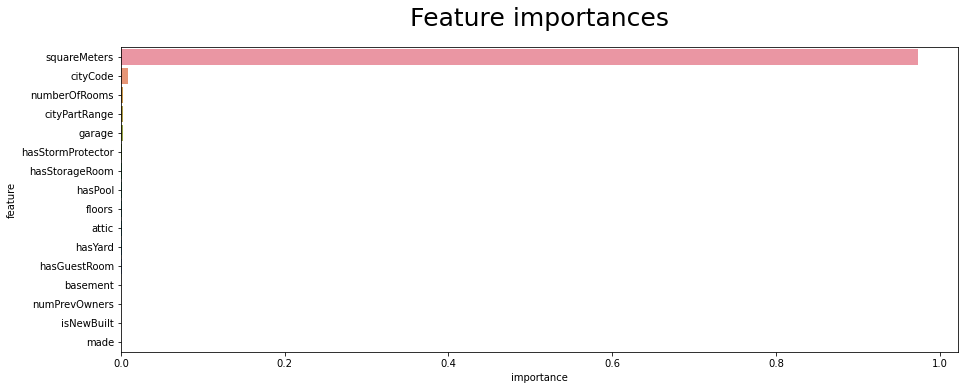

-------------------- LightGBM --------------------
Fold 0 	 RMSE: 170496.67014202784
Fold 1 	 RMSE: 138354.10550957813
Fold 2 	 RMSE: 139211.9505188844
Fold 3 	 RMSE: 269184.27131573
Fold 4 	 RMSE: 159962.03878855243
AVG RMSE: 175441.80725495456


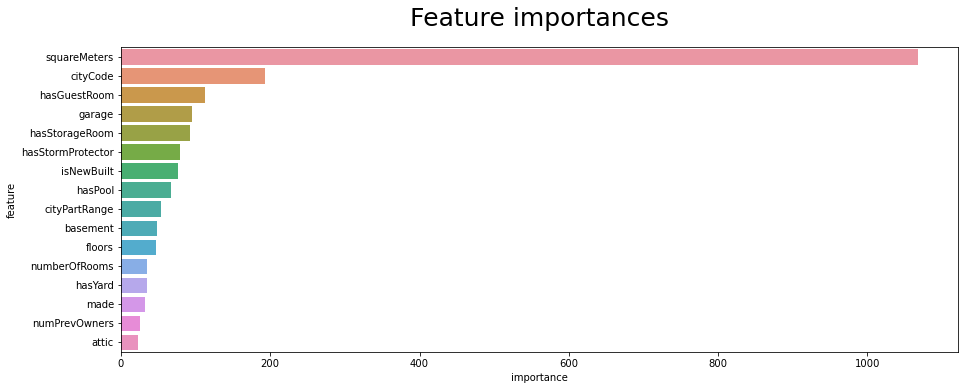

-------------------- CatBoost --------------------
Fold 0 	 RMSE: 171056.78831671967
Fold 1 	 RMSE: 147485.50541689328
Fold 2 	 RMSE: 120230.68813620023
Fold 3 	 RMSE: 259180.731698623
Fold 4 	 RMSE: 156865.69769466974
AVG RMSE: 170963.88225262117


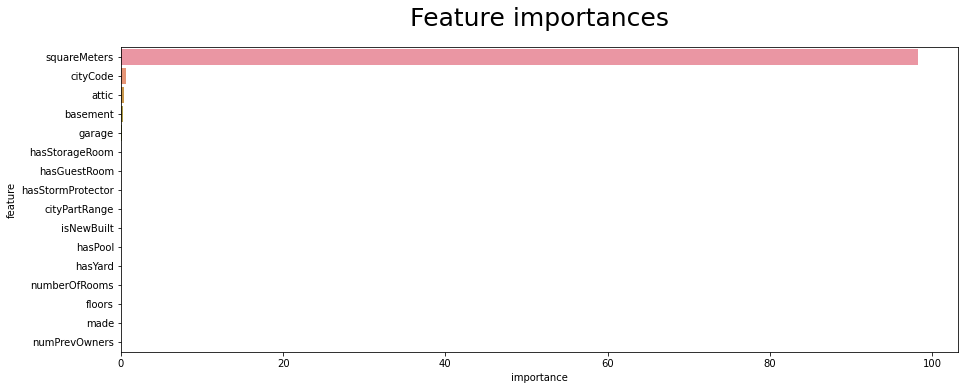

In [39]:
test_it(all_datasets)

# Preprocessing

In [40]:
processed_datasets = preprocess(all_datasets, target="price")
X = processed_datasets["train"]["data"]
y = processed_datasets["train"]["target"]

# Tuning XGBoost

In [41]:
processed_datasets = preprocess(all_datasets, target="price")
X = processed_datasets["train"]["data"]
y = processed_datasets["train"]["target"]

def objective_xgb(trial, X, y):
    params = {
        'tree_method': "gpu_hist",
        'n_estimators': trial.suggest_int('n_estimators', 50, 400),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 15),
        'gamma': trial.suggest_loguniform('gamma', 0.00001, 0.3),
        'subsample': trial.suggest_float('subsample', 0.2, 1.0, step=0.05),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0, step=0.05),
        'early_stopping_rounds': trial.suggest_int("early_stoppig_rounds", 40, 100)
    }
    # we're gonna train on the combined dataset but, we'll only calculate the validation score only on comp data

    N_FOLDS = 5
    all_scores = np.zeros(N_FOLDS)

    skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=1337)

    for fold_id, (train_idx, val_idx) in enumerate(skf.split(X)):
        
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model = xgb.XGBRegressor(**params)
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
        
        y_pred = model.predict(X_val)
                
        rmse = mean_squared_error(y_val, y_pred, squared=False)        
        all_scores[fold_id] = rmse
    
    avg_rmse = np.mean(all_scores)
    
    print(f"Avg RMSE: {avg_rmse}")
    
    return avg_rmse

study_xgb = optuna.create_study(study_name="xgboost_tuning", direction="minimize")
func = lambda trial: objective_xgb(trial, X, y)
study_xgb.optimize(func, n_trials=30)

In [42]:
study_xgb = optuna.create_study(study_name="xgboost_tuning", direction="minimize")
func = lambda trial: objective_xgb(trial, X, y)
study_xgb.optimize(func, n_trials=30)

[I 2023-02-14 17:53:28,400] A new study created in memory with name: xgboost_tuning
[I 2023-02-14 17:53:31,058] Trial 0 finished with value: 202673.40423492034 and parameters: {'n_estimators': 315, 'max_depth': 2, 'learning_rate': 0.18207691513292304, 'min_child_weight': 10, 'gamma': 0.0001873027520253802, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.75, 'early_stoppig_rounds': 85}. Best is trial 0 with value: 202673.40423492034.


Avg RMSE: 202673.40423492034


[I 2023-02-14 17:53:33,260] Trial 1 finished with value: 529189.9056800802 and parameters: {'n_estimators': 231, 'max_depth': 4, 'learning_rate': 0.01676868725307863, 'min_child_weight': 7, 'gamma': 0.006969144429109549, 'subsample': 0.7, 'colsample_bytree': 0.55, 'early_stoppig_rounds': 88}. Best is trial 0 with value: 202673.40423492034.


Avg RMSE: 529189.9056800802


[I 2023-02-14 17:53:59,403] Trial 2 finished with value: 186186.0500177931 and parameters: {'n_estimators': 332, 'max_depth': 20, 'learning_rate': 0.2077289514149904, 'min_child_weight': 9, 'gamma': 0.00021928707679239582, 'subsample': 0.55, 'colsample_bytree': 0.95, 'early_stoppig_rounds': 74}. Best is trial 2 with value: 186186.0500177931.


Avg RMSE: 186186.0500177931


[I 2023-02-14 17:54:35,592] Trial 3 finished with value: 643906.3587986438 and parameters: {'n_estimators': 149, 'max_depth': 13, 'learning_rate': 0.10406688943150352, 'min_child_weight': 7, 'gamma': 0.00860326011073118, 'subsample': 0.65, 'colsample_bytree': 0.5, 'early_stoppig_rounds': 74}. Best is trial 2 with value: 186186.0500177931.


Avg RMSE: 643906.3587986438


[I 2023-02-14 17:54:52,857] Trial 4 finished with value: 355104.65295189014 and parameters: {'n_estimators': 198, 'max_depth': 15, 'learning_rate': 0.18370024642639593, 'min_child_weight': 14, 'gamma': 2.46931789124769e-05, 'subsample': 0.5, 'colsample_bytree': 0.7, 'early_stoppig_rounds': 51}. Best is trial 2 with value: 186186.0500177931.


Avg RMSE: 355104.65295189014


[I 2023-02-14 17:54:54,737] Trial 5 finished with value: 201324.71879019277 and parameters: {'n_estimators': 121, 'max_depth': 6, 'learning_rate': 0.24080007715906987, 'min_child_weight': 8, 'gamma': 0.10423523921820825, 'subsample': 0.4, 'colsample_bytree': 0.9000000000000001, 'early_stoppig_rounds': 80}. Best is trial 2 with value: 186186.0500177931.


Avg RMSE: 201324.71879019277


[I 2023-02-14 17:55:13,466] Trial 6 finished with value: 858008.4110425122 and parameters: {'n_estimators': 59, 'max_depth': 15, 'learning_rate': 0.2019549015038206, 'min_child_weight': 11, 'gamma': 7.8880792584969e-05, 'subsample': 0.9000000000000001, 'colsample_bytree': 0.5, 'early_stoppig_rounds': 85}. Best is trial 2 with value: 186186.0500177931.


Avg RMSE: 858008.4110425122


[I 2023-02-14 17:55:54,997] Trial 7 finished with value: 351758.4253749036 and parameters: {'n_estimators': 346, 'max_depth': 16, 'learning_rate': 0.02321683431875699, 'min_child_weight': 13, 'gamma': 0.0013184798562124493, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.55, 'early_stoppig_rounds': 45}. Best is trial 2 with value: 186186.0500177931.


Avg RMSE: 351758.4253749036


[I 2023-02-14 17:56:08,210] Trial 8 finished with value: 865191.7976289194 and parameters: {'n_estimators': 254, 'max_depth': 8, 'learning_rate': 0.041321868251821416, 'min_child_weight': 4, 'gamma': 0.003156370997471673, 'subsample': 0.8, 'colsample_bytree': 0.2, 'early_stoppig_rounds': 100}. Best is trial 2 with value: 186186.0500177931.


Avg RMSE: 865191.7976289194


[I 2023-02-14 17:56:21,543] Trial 9 finished with value: 554062.8428643995 and parameters: {'n_estimators': 80, 'max_depth': 18, 'learning_rate': 0.0757942699400925, 'min_child_weight': 12, 'gamma': 0.00012124298858329837, 'subsample': 0.35000000000000003, 'colsample_bytree': 0.45, 'early_stoppig_rounds': 47}. Best is trial 2 with value: 186186.0500177931.


Avg RMSE: 554062.8428643995


[I 2023-02-14 17:57:15,648] Trial 10 finished with value: 187370.23464401456 and parameters: {'n_estimators': 399, 'max_depth': 20, 'learning_rate': 0.04651475551787142, 'min_child_weight': 2, 'gamma': 1.70999096864751e-05, 'subsample': 0.2, 'colsample_bytree': 1.0, 'early_stoppig_rounds': 60}. Best is trial 2 with value: 186186.0500177931.


Avg RMSE: 187370.23464401456


[I 2023-02-14 17:58:16,235] Trial 11 finished with value: 190475.12934458983 and parameters: {'n_estimators': 398, 'max_depth': 20, 'learning_rate': 0.047381551472121426, 'min_child_weight': 1, 'gamma': 1.2697245090605003e-05, 'subsample': 0.25, 'colsample_bytree': 1.0, 'early_stoppig_rounds': 62}. Best is trial 2 with value: 186186.0500177931.


Avg RMSE: 190475.12934458983


[I 2023-02-14 17:58:42,733] Trial 12 finished with value: 208694.7669709029 and parameters: {'n_estimators': 400, 'max_depth': 19, 'learning_rate': 0.010363444948384967, 'min_child_weight': 4, 'gamma': 1.0167396760654942e-05, 'subsample': 0.2, 'colsample_bytree': 1.0, 'early_stoppig_rounds': 63}. Best is trial 2 with value: 186186.0500177931.


Avg RMSE: 208694.7669709029


[I 2023-02-14 18:00:04,546] Trial 13 finished with value: 236962.588316574 and parameters: {'n_estimators': 326, 'max_depth': 11, 'learning_rate': 0.10759633395548687, 'min_child_weight': 1, 'gamma': 0.00037925220535879264, 'subsample': 1.0, 'colsample_bytree': 0.8500000000000001, 'early_stoppig_rounds': 60}. Best is trial 2 with value: 186186.0500177931.


Avg RMSE: 236962.588316574


[I 2023-02-14 18:02:34,790] Trial 14 finished with value: 275373.8944850012 and parameters: {'n_estimators': 280, 'max_depth': 20, 'learning_rate': 0.03945724806213563, 'min_child_weight': 4, 'gamma': 4.526224294730481e-05, 'subsample': 0.5, 'colsample_bytree': 0.8500000000000001, 'early_stoppig_rounds': 69}. Best is trial 2 with value: 186186.0500177931.


Avg RMSE: 275373.8944850012


[I 2023-02-14 18:03:36,967] Trial 15 finished with value: 380504.8313997046 and parameters: {'n_estimators': 358, 'max_depth': 17, 'learning_rate': 0.07010482515463241, 'min_child_weight': 9, 'gamma': 4.136602061887765e-05, 'subsample': 0.45, 'colsample_bytree': 0.7, 'early_stoppig_rounds': 55}. Best is trial 2 with value: 186186.0500177931.


Avg RMSE: 380504.8313997046


[I 2023-02-14 18:04:12,128] Trial 16 finished with value: 1157090.016562147 and parameters: {'n_estimators': 296, 'max_depth': 11, 'learning_rate': 0.2916979328576105, 'min_child_weight': 6, 'gamma': 0.00042508510354964874, 'subsample': 0.75, 'colsample_bytree': 0.35000000000000003, 'early_stoppig_rounds': 40}. Best is trial 2 with value: 186186.0500177931.


Avg RMSE: 1157090.016562147


[I 2023-02-14 18:04:24,987] Trial 17 finished with value: 183838.9137090469 and parameters: {'n_estimators': 365, 'max_depth': 13, 'learning_rate': 0.12867765196373845, 'min_child_weight': 5, 'gamma': 4.6069356407579904e-05, 'subsample': 0.55, 'colsample_bytree': 0.95, 'early_stoppig_rounds': 73}. Best is trial 17 with value: 183838.9137090469.


Avg RMSE: 183838.9137090469


[I 2023-02-14 18:04:30,522] Trial 18 finished with value: 205808.05344395913 and parameters: {'n_estimators': 354, 'max_depth': 9, 'learning_rate': 0.13753764207739017, 'min_child_weight': 15, 'gamma': 9.05681462345254e-05, 'subsample': 0.55, 'colsample_bytree': 0.9000000000000001, 'early_stoppig_rounds': 73}. Best is trial 17 with value: 183838.9137090469.


Avg RMSE: 205808.05344395913


[I 2023-02-14 18:05:08,973] Trial 19 finished with value: 362938.08967084234 and parameters: {'n_estimators': 198, 'max_depth': 13, 'learning_rate': 0.14004714790095335, 'min_child_weight': 5, 'gamma': 0.0003304035426844873, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.75, 'early_stoppig_rounds': 94}. Best is trial 17 with value: 183838.9137090469.


Avg RMSE: 362938.08967084234


[I 2023-02-14 18:05:38,794] Trial 20 finished with value: 648006.180301313 and parameters: {'n_estimators': 246, 'max_depth': 13, 'learning_rate': 0.28446402169542695, 'min_child_weight': 9, 'gamma': 4.111760755035784e-05, 'subsample': 0.8500000000000001, 'colsample_bytree': 0.65, 'early_stoppig_rounds': 79}. Best is trial 17 with value: 183838.9137090469.


Avg RMSE: 648006.180301313


[I 2023-02-14 18:06:28,470] Trial 21 finished with value: 181167.92299911284 and parameters: {'n_estimators': 374, 'max_depth': 18, 'learning_rate': 0.07407429174737869, 'min_child_weight': 2, 'gamma': 2.2011581381167224e-05, 'subsample': 0.4, 'colsample_bytree': 1.0, 'early_stoppig_rounds': 67}. Best is trial 21 with value: 181167.92299911284.


Avg RMSE: 181167.92299911284


[I 2023-02-14 18:07:29,620] Trial 22 finished with value: 263702.28026316874 and parameters: {'n_estimators': 370, 'max_depth': 17, 'learning_rate': 0.09334077211099108, 'min_child_weight': 3, 'gamma': 2.9812130936165097e-05, 'subsample': 0.4, 'colsample_bytree': 0.9000000000000001, 'early_stoppig_rounds': 68}. Best is trial 21 with value: 181167.92299911284.


Avg RMSE: 263702.28026316874


[I 2023-02-14 18:08:37,200] Trial 23 finished with value: 400355.0029597223 and parameters: {'n_estimators': 324, 'max_depth': 18, 'learning_rate': 0.13950104124700216, 'min_child_weight': 6, 'gamma': 8.116816096589517e-05, 'subsample': 0.5, 'colsample_bytree': 0.8, 'early_stoppig_rounds': 77}. Best is trial 21 with value: 181167.92299911284.


Avg RMSE: 400355.0029597223


[I 2023-02-14 18:09:13,714] Trial 24 finished with value: 172685.16649670416 and parameters: {'n_estimators': 281, 'max_depth': 15, 'learning_rate': 0.06626291886910365, 'min_child_weight': 3, 'gamma': 1.0307939694089527e-05, 'subsample': 0.65, 'colsample_bytree': 0.95, 'early_stoppig_rounds': 65}. Best is trial 24 with value: 172685.16649670416.


Avg RMSE: 172685.16649670416


[I 2023-02-14 18:10:01,027] Trial 25 finished with value: 171306.67535606268 and parameters: {'n_estimators': 278, 'max_depth': 14, 'learning_rate': 0.06195030061749075, 'min_child_weight': 2, 'gamma': 1.3204096863248192e-05, 'subsample': 0.7, 'colsample_bytree': 0.95, 'early_stoppig_rounds': 66}. Best is trial 25 with value: 171306.67535606268.


Avg RMSE: 171306.67535606268


[I 2023-02-14 18:12:53,825] Trial 26 finished with value: 429500.67380041146 and parameters: {'n_estimators': 276, 'max_depth': 15, 'learning_rate': 0.06578894259015175, 'min_child_weight': 2, 'gamma': 1.0818450263073962e-05, 'subsample': 0.7, 'colsample_bytree': 0.8, 'early_stoppig_rounds': 55}. Best is trial 25 with value: 171306.67535606268.


Avg RMSE: 429500.67380041146


[I 2023-02-14 18:13:38,421] Trial 27 finished with value: 169956.25197507697 and parameters: {'n_estimators': 201, 'max_depth': 14, 'learning_rate': 0.05766732304897301, 'min_child_weight': 2, 'gamma': 1.724318470367816e-05, 'subsample': 0.7, 'colsample_bytree': 0.95, 'early_stoppig_rounds': 65}. Best is trial 27 with value: 169956.25197507697.


Avg RMSE: 169956.25197507697


[I 2023-02-14 18:14:01,514] Trial 28 finished with value: 216190.3453409633 and parameters: {'n_estimators': 192, 'max_depth': 10, 'learning_rate': 0.055499393798716684, 'min_child_weight': 3, 'gamma': 1.8150253426086263e-05, 'subsample': 0.75, 'colsample_bytree': 0.8500000000000001, 'early_stoppig_rounds': 65}. Best is trial 27 with value: 169956.25197507697.


Avg RMSE: 216190.3453409633


[I 2023-02-14 18:15:37,894] Trial 29 finished with value: 393992.0663457442 and parameters: {'n_estimators': 164, 'max_depth': 14, 'learning_rate': 0.033664588278755576, 'min_child_weight': 1, 'gamma': 1.0326163917164875e-05, 'subsample': 0.65, 'colsample_bytree': 0.75, 'early_stoppig_rounds': 57}. Best is trial 27 with value: 169956.25197507697.


Avg RMSE: 393992.0663457442


In [43]:
study_xgb.best_value

169956.25197507697

In [44]:
study_xgb.best_params

{'n_estimators': 201,
 'max_depth': 14,
 'learning_rate': 0.05766732304897301,
 'min_child_weight': 2,
 'gamma': 1.724318470367816e-05,
 'subsample': 0.7,
 'colsample_bytree': 0.95,
 'early_stoppig_rounds': 65}

# Feature Engineering

In [45]:
#  ------------ We need this for our feature number 8 -----------------
train_copy = all_datasets["train"]
train_copy["block_number"] = train_copy.cityCode // 75
# lets find the average house prices for blocks
avg_house_cost_per_block = train_copy.groupby("block_number")["price"].mean().to_dict()
# ---------------------------------------------------------------------------


def engineer_features(all_datasets):
    all_datasets_fe = {}
    for name, _dataset in all_datasets.items():
        dataset = _dataset.copy()
        # FeatIdea #1: guestRooms/numberOfRooms
        dataset["guestRooms_/_numberOfRooms"] = dataset.hasGuestRoom / dataset.numberOfRooms

        # FeatIdea #2: Number of non guest rooms: NumOfRooms - GuestRooms
        dataset["non_guest_rooms"] = dataset.numberOfRooms - dataset.hasGuestRoom

        # FeatIdea #3: Rooms/Floors: Number of rooms per floor
        dataset["rooms_per_floor"] = dataset.numberOfRooms // dataset.floors

        # FeatIdea #4: Attic/squareMeters:  Attic size to total house size ratio
        dataset["attic_/_squareMeters"] = dataset.attic / dataset.squareMeters

        # FeatIdea #5: Basement/squareMeters: Basement size to total house size ratio
        dataset["basement_/_squareMeters"] = dataset.basement / dataset.squareMeters

        # FeatIdea #6. Garage/squareMeters: Garage size to total house size ratio
        dataset["garage_/_squareMeters"] = dataset.garage / dataset.squareMeters

        # FeatIdea #7: Grouping zip codes
        dataset["block_number"] = dataset.cityCode // 75

        # FeatIdea #8: Add avg price per block as a feature.
        dataset["avg_house_price_in_block"] = dataset.block_number.map(avg_house_cost_per_block)
        
        all_datasets_fe[name] = dataset
    
    return all_datasets_fe

In [46]:
all_datasets_fe = engineer_features(all_datasets)

In [47]:
feats_to_drop = ["cityCode", "block_number", "attic", "basement", "garage",
                 "hasPool", "hasYard", "hasStormProtector", "isNewBuilt"]

In [48]:
for _, dataset in all_datasets_fe.items():
    dataset.drop(columns=feats_to_drop, inplace=True)

-------------------- XGBoost --------------------
Fold 0 	 RMSE: 176023.7116871145
Fold 1 	 RMSE: 158591.0124297052
Fold 2 	 RMSE: 87236.15230744396
Fold 3 	 RMSE: 197010.66486741762
Fold 4 	 RMSE: 225957.34503298465
AVG RMSE: 168963.77726493316


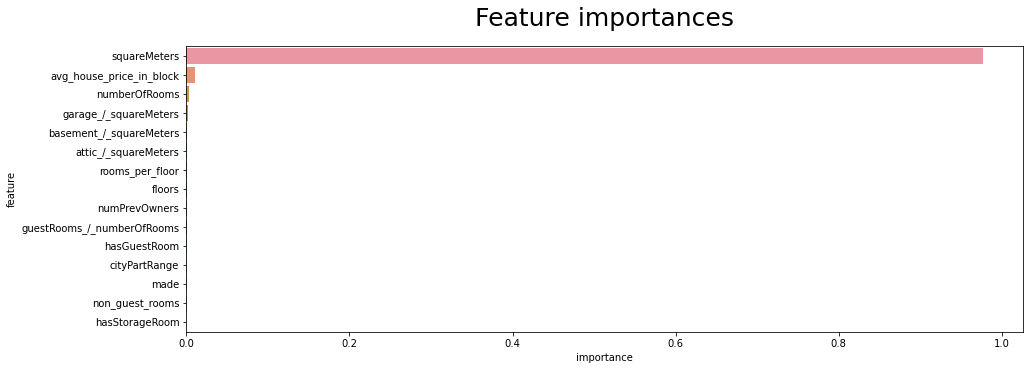

-------------------- LightGBM --------------------
Fold 0 	 RMSE: 180827.4340041601
Fold 1 	 RMSE: 131339.27155563416
Fold 2 	 RMSE: 120403.10817445937
Fold 3 	 RMSE: 250598.03018034817
Fold 4 	 RMSE: 149953.82834175008
AVG RMSE: 166624.33445127038


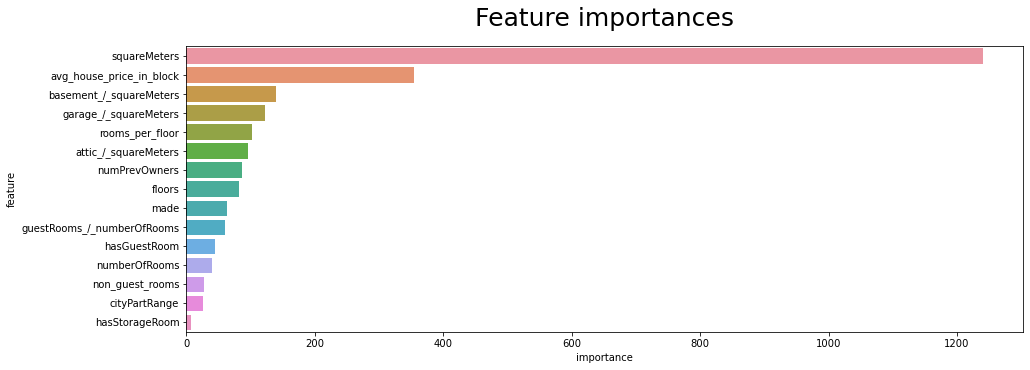

-------------------- CatBoost --------------------
Fold 0 	 RMSE: 173924.2129765917
Fold 1 	 RMSE: 136257.73786409223
Fold 2 	 RMSE: 114183.85663580966
Fold 3 	 RMSE: 234407.66795910406
Fold 4 	 RMSE: 139464.74138357356
AVG RMSE: 159647.6433638342


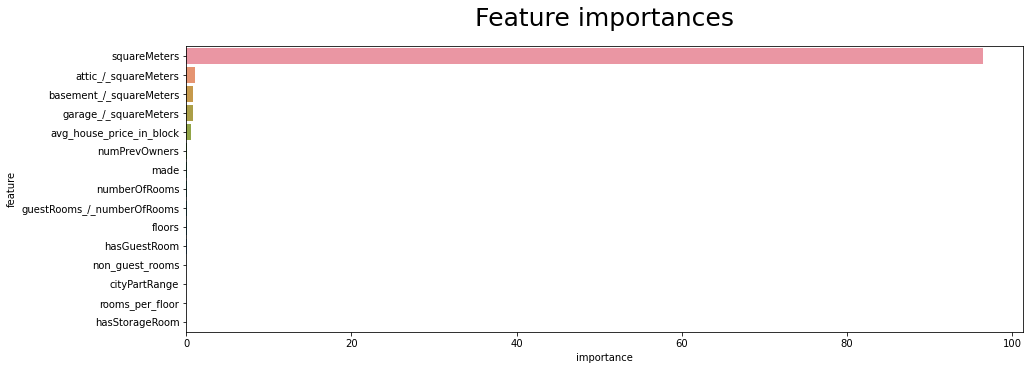

In [55]:
test_it(all_datasets_fe)

## Results:
All models show significant imporvement

But what's common in all three is that our newly added features seem to be quite important in making decisions.

In [ ]:
processed_datasets = preprocess(all_datasets_fe, target="price")
X = processed_datasets["train"]["data"]
y = processed_datasets["train"]["target"]

def objective_xgb(trial, X, y):
    params = {
        'tree_method': "gpu_hist",
        'n_estimators': trial.suggest_int('n_estimators', 50, 400),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 15),
        'gamma': trial.suggest_loguniform('gamma', 0.00001, 0.3),
        'subsample': trial.suggest_float('subsample', 0.2, 1.0, step=0.05),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0, step=0.05),
        'early_stopping_rounds': trial.suggest_int("early_stoppig_rounds", 40, 100)
    }
    # we're gonna train on the combined dataset but, we'll only calculate the validation score only on comp data

    N_FOLDS = 5
    all_scores = np.zeros(N_FOLDS)

    skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=1337)

    for fold_id, (train_idx, val_idx) in enumerate(skf.split(X)):
        
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model = xgb.XGBRegressor(**params)
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
        
        y_pred = model.predict(X_val)
                
        rmse = mean_squared_error(y_val, y_pred, squared=False)        
        all_scores[fold_id] = rmse
    
    avg_rmse = np.mean(all_scores)
    
    print(f"Avg RMSE: {avg_rmse}")
    
    return avg_rmse

study_xgb = optuna.create_study(study_name="xgboost_tuning", direction="minimize")
func = lambda trial: objective_xgb(trial, X, y)
study_xgb.optimize(func, n_trials=30)

[I 2023-02-14 18:24:30,912] A new study created in memory with name: xgboost_tuning
[I 2023-02-14 18:24:33,294] Trial 0 finished with value: 279677.9410898177 and parameters: {'n_estimators': 337, 'max_depth': 2, 'learning_rate': 0.027113624443682052, 'min_child_weight': 8, 'gamma': 0.00028845973845899737, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.65, 'early_stoppig_rounds': 77}. Best is trial 0 with value: 279677.9410898177.


Avg RMSE: 279677.9410898177


[I 2023-02-14 18:24:34,829] Trial 1 finished with value: 223876.66495560348 and parameters: {'n_estimators': 203, 'max_depth': 3, 'learning_rate': 0.14250116300377139, 'min_child_weight': 9, 'gamma': 0.012749463148897812, 'subsample': 0.5, 'colsample_bytree': 0.45, 'early_stoppig_rounds': 58}. Best is trial 1 with value: 223876.66495560348.


Avg RMSE: 223876.66495560348


[I 2023-02-14 18:25:27,432] Trial 2 finished with value: 273947.7611361362 and parameters: {'n_estimators': 314, 'max_depth': 16, 'learning_rate': 0.050492768542024356, 'min_child_weight': 7, 'gamma': 0.25412881082321365, 'subsample': 0.25, 'colsample_bytree': 0.4, 'early_stoppig_rounds': 88}. Best is trial 1 with value: 223876.66495560348.


Avg RMSE: 273947.7611361362


# Training models

In [85]:
processed_datasets = preprocess(all_datasets, "price")
X_train, y_train = processed_datasets["train"].values()
# X_combined, y_combined = processed_datasets["combined"].values()
X_test = processed_datasets["test"]["data"]

In [86]:
# we need a validation set, but only of those samples that are from teh competition dataset
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, 
                                          shuffle=True, random_state=1337,
                                         test_size=0.15)

# X_combined.drop(X_val.index, inplace=True)
# y_combined.drop(y_val.index, inplace=True)

In [87]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_t, y_t,
              eval_set=[(X_val, y_val)],
              eval_metric="rmse", verbose=False,
             early_stopping_rounds=50)

lgbm_model = lgbm.LGBMRegressor()
lgbm_model.fit(X_t, y_t,
               eval_set=[(X_val, y_val)],
               eval_metric="rmse", verbose=-1,
              early_stopping_rounds=50)

catboost_model = catboost.CatBoostRegressor(eval_metric="RMSE")
catboost_model.fit(X_t, y_t,
                   eval_set=[(X_val, y_val)],
                   early_stopping_rounds=50,
                   verbose=False)

# Ensembling

In [88]:
y_pred_xgb = xgb_model.predict(X_test)
y_pred_lgbm = lgbm_model.predict(X_test)
y_pred_cat = catboost_model.predict(X_test)

ValueError: Feature shape mismatch, expected: 17, got 16

In [ ]:
y_pred_final = np.array([y_pred_xgb, y_pred_lgbm, y_pred_cat]).mean(axis=0)
# y_pred_final = y_pred_cat

# Submission

In [ ]:
submission = pd.DataFrame({"id": test_idx, "price": y_pred_final})
submission.head()

In [ ]:
submission.to_csv("submission.csv", index=False)